In [19]:
VERSION = 'Current'
from SOH_func import *
import matplotlib.pyplot as pl
from tensorflow import summary as sm
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
FILE_00 = 'CYCLE_CSV_data.csv'
FILE_01 = 'CYCLE_CSV_data01.csv'
FILE_02 = 'CYCLE_CSV_data02.csv'
# drop_labels = ['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '누적_용량(Ah)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)']
drop_labels_x = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']

Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
Index(['방전_용량(Ah)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data00 = (510, 2)


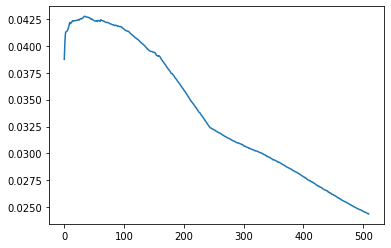

data01 = (480, 2)


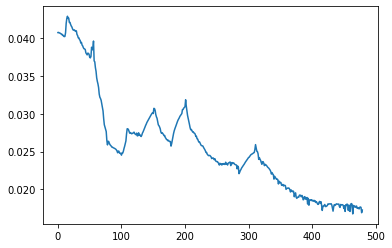

data_test = (480, 2)


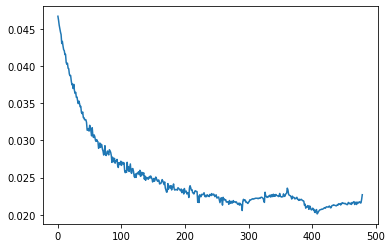

In [21]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_02, drop_labels_x, drop_labels_y)
data01 = data01[70:]
data_cap01 = data_cap01[70:]
data_test = data_test[70:]
data_cap_test = data_cap_test[70:]
print(f'data00 = {data00.shape}')
pl.plot(data_cap00)
pl.show()
print(f'data01 = {data01.shape}')
pl.plot(data_cap01)
pl.show()
print(f'data_test = {data_test.shape}')
pl.plot(data_cap_test)
pl.show()

In [22]:
param = {'seq_len' : 25, 'sample_len' : 25, 'num_units' : 64, 'num_filters' : 64, 'window' : 3, 'drop_rate' : 0.2, 'num_epochs' : 4000}
x_train00, y_train00, num_batch00  = seq_gen(data00, data_cap00, param['seq_len'])
x_train01, y_train01, num_batch01  = seq_gen(data01, data_cap01, param['seq_len'])
x_test, y_test, num_batch_test  = seq_gen(data_test, data_cap_test, param['seq_len'])
print(x_train00.shape)

num_batch = 20
x = (20, 25, 2)
y = (20, 25, 1)
num_batch = 19
x = (19, 25, 2)
y = (19, 25, 1)
num_batch = 19
x = (19, 25, 2)
y = (19, 25, 1)
(20, 25, 2)


In [23]:
model = models.Sequential()
model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
model.add(layers.LSTM(param['num_units'], return_sequences = True))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 64)          448       
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 time_distributed_2 (TimeDis  (None, None, 1)          65        
 tributed)                                                       
                                                                 
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
_________________________________________________________________


In [24]:
epoch_index = 0
loss_dict = {}
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_path = f'Checkpoints\SOH_{VERSION}_Checkpoint\{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'
hist_freq = 80

In [25]:
epoch_index += param['num_epochs']
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 2, validation_split = 0.3, callbacks=callback_list)

Epoch 1/4000
1/1 - 1s - loss: 0.0012 - val_loss: 5.8058e-05 - 1s/epoch - 1s/step
Epoch 2/4000
1/1 - 0s - loss: 1.8180e-04 - val_loss: 4.0771e-04 - 25ms/epoch - 25ms/step
Epoch 3/4000
1/1 - 0s - loss: 3.1616e-04 - val_loss: 7.0135e-04 - 26ms/epoch - 26ms/step
Epoch 4/4000
1/1 - 0s - loss: 5.6953e-04 - val_loss: 5.4867e-04 - 22ms/epoch - 22ms/step
Epoch 5/4000
1/1 - 0s - loss: 4.2641e-04 - val_loss: 2.7796e-04 - 24ms/epoch - 24ms/step
Epoch 6/4000
1/1 - 0s - loss: 2.0011e-04 - val_loss: 9.7259e-05 - 27ms/epoch - 27ms/step
Epoch 7/4000
1/1 - 0s - loss: 9.2726e-05 - val_loss: 3.7602e-05 - 38ms/epoch - 38ms/step
Epoch 8/4000
1/1 - 0s - loss: 1.1418e-04 - val_loss: 4.3973e-05 - 23ms/epoch - 23ms/step
Epoch 9/4000
1/1 - 0s - loss: 1.8437e-04 - val_loss: 5.6943e-05 - 23ms/epoch - 23ms/step
Epoch 10/4000
1/1 - 0s - loss: 2.2796e-04 - val_loss: 5.1288e-05 - 23ms/epoch - 23ms/step
Epoch 11/4000
1/1 - 0s - loss: 2.1724e-04 - val_loss: 3.3979e-05 - 45ms/epoch - 45ms/step
Epoch 12/4000
1/1 - 0s - lo

KeyboardInterrupt: 

In [ ]:
epoch_index += param['num_epochs']
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 2, validation_split = 0.3, callbacks=callback_list)

Epoch 1/4000
1/1 - 0s - loss: 5.0203e-06 - val_loss: 3.7961e-05 - 68ms/epoch - 68ms/step
Epoch 2/4000
1/1 - 0s - loss: 2.4098e-05 - val_loss: 8.8214e-06 - 37ms/epoch - 37ms/step
Epoch 3/4000
1/1 - 0s - loss: 2.1848e-05 - val_loss: 4.3728e-06 - 37ms/epoch - 37ms/step
Epoch 4/4000
1/1 - 0s - loss: 1.6542e-06 - val_loss: 1.1755e-05 - 20ms/epoch - 20ms/step
Epoch 5/4000
1/1 - 0s - loss: 9.0992e-06 - val_loss: 8.3359e-06 - 20ms/epoch - 20ms/step
Epoch 6/4000
1/1 - 0s - loss: 1.0514e-05 - val_loss: 9.0342e-07 - 36ms/epoch - 36ms/step
Epoch 7/4000
1/1 - 0s - loss: 3.9750e-07 - val_loss: 5.7743e-06 - 21ms/epoch - 21ms/step
Epoch 8/4000
1/1 - 0s - loss: 9.2738e-06 - val_loss: 3.7626e-06 - 21ms/epoch - 21ms/step
Epoch 9/4000
1/1 - 0s - loss: 1.4598e-06 - val_loss: 1.0723e-05 - 21ms/epoch - 21ms/step
Epoch 10/4000
1/1 - 0s - loss: 5.7439e-06 - val_loss: 8.6284e-07 - 37ms/epoch - 37ms/step
Epoch 11/4000
1/1 - 0s - loss: 3.3629e-06 - val_loss: 7.7149e-07 - 35ms/epoch - 35ms/step
Epoch 12/4000
1/1 -

1/1 [==============================] - 0s 211ms/step
(475, 1) (475, 1)
EstimationCurrent-64FL-64UN-8000EP-25SQ


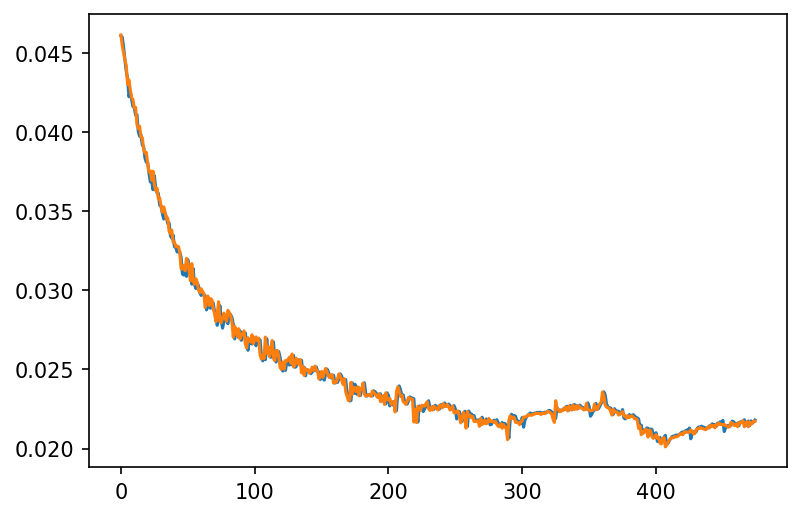

In [ ]:
show_and_prove(model, VERSION, file_path, epoch_index, x_test, y_test, loss_dict, param)